In [1]:
import pandas as pd
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.preprocessing import StandardScaler

In [2]:
interpolated_weather_df = pd.read_csv('data/region/vietnam/interpolated_weather.csv', index_col=0, parse_dates=True)
interpolated_air_df = pd.read_csv('data/region/vietnam/interpolated_air.csv', index_col=0, parse_dates=True)

In [10]:
interpolated_air_df.drop(columns='aqi', inplace=True)

In [11]:
interpolated_air_df = interpolated_air_df.reset_index().set_index(['time', 'province'])
interpolated_weather_df = interpolated_weather_df.reset_index().set_index(['time', 'province'])

In [12]:
air_unstacked = interpolated_air_df.unstack(level='province').asfreq('h')
weather_unstacked = interpolated_weather_df.unstack(level='province').asfreq('h')

In [14]:
air_train, air_test = air_unstacked.loc[:'2023-12-31 23:00:00'], air_unstacked.loc['2024-01-01 00:00:00':]
weather_train, weather_test = weather_unstacked.loc[:'2023-12-31 23:00:00'], weather_unstacked.loc['2024-01-01 00:00:00':]

In [15]:
air_scaler = StandardScaler()
weather_scaler = StandardScaler()

In [16]:
air_normalized = air_scaler.fit_transform(air_train.to_numpy())
weather_normalized = weather_scaler.fit_transform(weather_train.to_numpy())

In [17]:
air_normalized = pd.DataFrame(air_normalized, columns=air_train.columns, index=air_train.index)
weather_normalized = pd.DataFrame(weather_normalized, columns=weather_train.columns, index=weather_train.index)

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=0.9)

In [20]:
air_pca = pca.fit(air_normalized)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

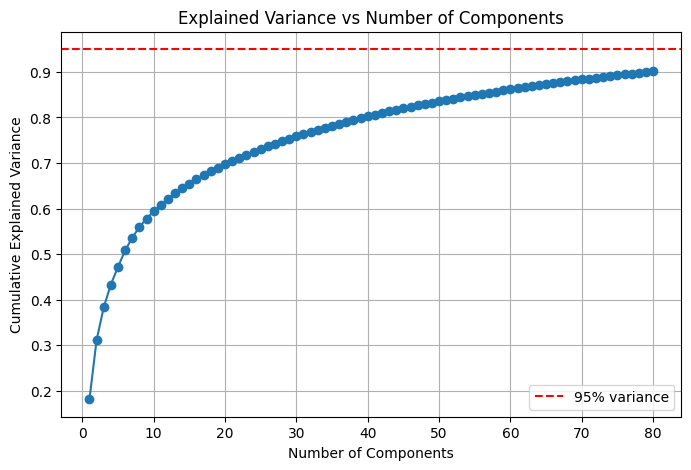

In [22]:
cumulative_variance = np.cumsum(air_pca.explained_variance_ratio_)

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.grid()
plt.show()

In [10]:
model = VARMAX(air_normalized, exog=weather_normalized, order=(0,2), trend='ct')

In [ ]:
results = model.fit(maxiter=1, method='lbfgs')

In [ ]:
results.save('varmax.pickle')